# Project 7 - Vital sign

**Author: Linh Nguyen**<br>

**StudentID: 23161711**<br>


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Capstone_project


In [2]:
! ls /content/drive/MyDrive/Capstone_project/raw

diagnosis.csv  icd9toicd10cmgem.csv  pyxis.csv	 vitalsign.csv
edstays.csv    medrecon.csv	     triage.csv


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import  tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report, roc_auc_score

# 2. Data cleansing


In [4]:
edstays = pd.read_csv('raw/edstays.csv')
edstays['y_var_adm_text'] = edstays['disposition']
edstays['intime_h'] = pd.to_datetime(edstays.intime).dt.hour
edstays.loc[edstays['y_var_adm_text'] == 'ADMITTED', 'y_var_adm_text'] = 'NOT_DIED'
edstays.loc[edstays['y_var_adm_text'] == 'HOME', 'y_var_adm_text'] = 'NOT_DIED'
edstays.loc[edstays['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'NOT_DIED'
edstays.loc[edstays['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'DIED'
edstays_admit = edstays[edstays['y_var_adm_text'] !='MISSING'].reset_index(drop = True)
edstays_admit['key'] = edstays_admit['subject_id'].astype(str)+'_'+edstays_admit['stay_id'].astype(str)

In [5]:
edstays_admit.loc[edstays_admit['race'].str.contains('WHITE'), 'race_color'] = 'WHITE'
edstays_admit.loc[edstays_admit['race'].str.contains('BLACK'), 'race_color'] = 'BLACK'
edstays_admit.loc[edstays_admit['race'].str.contains('ASIAN'), 'race_color'] = 'ASIAN'
edstays_admit.loc[edstays_admit['race'].str.contains('LATINO'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit.loc[edstays_admit['race'].str.contains('HISPANIC'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit.loc[edstays_admit['race_color'].isna(), 'race_color'] = 'OTHER'

In [6]:
edstays_admit['DateTime_in'] = pd.to_datetime(edstays_admit['intime'], format='%d/%m/%Y %H:%M')
edstays_admit['DateTime_out'] = pd.to_datetime(edstays_admit['outtime'], format='%d/%m/%Y %H:%M')

In [7]:
edstays_admit['stay'] = edstays_admit['DateTime_out'] - edstays_admit['DateTime_in']

In [8]:
edstays_admit_1 = edstays_admit.sort_values(by = ['subject_id','DateTime_in'], ascending=True).reset_index(drop=True)

In [9]:
edstay_hist = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_hist[i] = 'NO HISTORY'
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_hist[i] = edstays_admit_1['disposition'][i-1]
        else:
            edstay_hist[i] = 'NO HISTORY'

In [10]:
edstay_laststay = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_laststay[i] = np.timedelta64(0, 'D')
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]: 
          edstay_laststay[i] = edstays_admit_1['stay'][i-1]+edstay_laststay[i-1]
        else:
            edstay_laststay[i] = np.timedelta64(0, 'D')

In [11]:
df1 = pd.DataFrame.from_dict(edstay_hist,orient='index')
df1.columns = ['historical_stay_status']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

In [12]:
df1 = pd.DataFrame.from_dict(edstay_laststay,orient='index')
df1.columns = ['historical_stay_length']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

In [13]:
edstays_admit_1['historical_stay_length_in_day'] = edstays_admit_1['historical_stay_length']/(np.timedelta64(1, 'D'))

In [14]:
edstays_admit_2 = pd.merge(edstays_admit,edstays_admit_1[['historical_stay_status','historical_stay_length','historical_stay_length_in_day','subject_id','stay_id']],how = 'left',on=['subject_id', 'stay_id'])

In [15]:
edstays_admit_2.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'y_var_adm_text',
       'intime_h', 'key', 'race_color', 'DateTime_in', 'DateTime_out', 'stay',
       'historical_stay_status', 'historical_stay_length',
       'historical_stay_length_in_day'],
      dtype='object')

In [16]:
triage = pd.read_csv('raw/triage.csv')


In [17]:
edstay_ad = pd.merge(edstays_admit_2,triage,how = 'left',on=['subject_id', 'stay_id'])

In [18]:
edstay_ad['y_var'] = 0
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'DIED', 'y_var']  = 1

In [19]:
edstay_ad.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'y_var_adm_text',
       'intime_h', 'key', 'race_color', 'DateTime_in', 'DateTime_out', 'stay',
       'historical_stay_status', 'historical_stay_length',
       'historical_stay_length_in_day', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'y_var'],
      dtype='object')

In [20]:
vital = pd.read_csv('raw/vitalsign.csv')

(array([3.12952e+05, 8.34000e+04, 1.88980e+04, 9.34400e+03, 2.56300e+03,
        1.50100e+03, 6.14000e+02, 2.22000e+02, 1.69000e+02, 5.70000e+01,
        4.40000e+01, 2.40000e+01, 1.20000e+01, 1.20000e+01, 7.00000e+00,
        3.00000e+00, 3.00000e+00, 0.00000e+00, 6.00000e+00, 1.00000e+00,
        3.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  1. ,   4.6,   8.2,  11.8,  15.4,  19. ,  22.6,  26.2,  29.8,
         33.4,  37. ,  40.6,  44.2,  47.8,  51.4,  55. ,  58.6,  62.2,
         65.8,  69.4,  73. ,  76.6,  80.2,  83.8,  87.4,  91. ,  94.6,
         98.2, 101.8, 105.4, 109. ]),
 <a list of 30 Patch objects>)

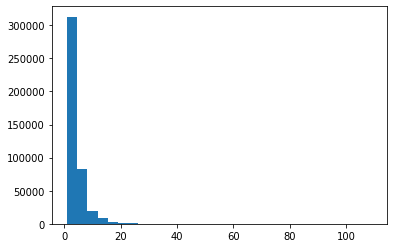

In [21]:
plt.hist(vital.groupby(['subject_id', 'stay_id']).size(), bins = 30)

(array([184241., 128711.,  56147.,  27253.,   8347.,  10551.,   5990.,
          3354.,   1927.,   1158.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <a list of 10 Patch objects>)

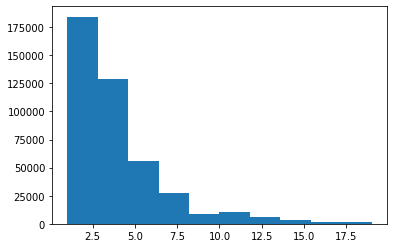

In [22]:
plt.hist(vital.groupby(['subject_id', 'stay_id']).size()[vital.groupby(['subject_id', 'stay_id']).size()<20])

In [23]:
edstay_ad1 = edstay_ad.drop(['subject_id','hadm_id','stay_id','intime','outtime','race', 'gender','race_color','disposition','y_var_adm_text','key', 'DateTime_in', 'DateTime_out','stay','historical_stay_length','chiefcomplaint', 'pain', 'y_var'], axis = 1)

In [24]:
vital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646976 entries, 0 to 1646975
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   subject_id   1646976 non-null  int64  
 1   stay_id      1646976 non-null  int64  
 2   charttime    1646976 non-null  object 
 3   temperature  1052781 non-null  float64
 4   heartrate    1573609 non-null  float64
 5   resprate     1552909 non-null  float64
 6   o2sat        1503831 non-null  float64
 7   sbp          1561439 non-null  float64
 8   dbp          1561439 non-null  float64
 9   rhythm       62792 non-null    object 
 10  pain         1180066 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 138.2+ MB


In [25]:
edstay_ad2 = edstay_ad[['subject_id','stay_id','y_var']]
vital2 = pd.merge(edstay_ad2, vital, how = 'left',on=['subject_id', 'stay_id'])

In [26]:
vital2['charttime'] = pd.to_datetime(vital2['charttime'], format='%Y-%m-%d %H:%M')

In [27]:
my_imputer = SimpleImputer(strategy = 'median')
num_attr = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
vital2[num_attr] = my_imputer.fit_transform(vital2[num_attr])
vital2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1627625 entries, 0 to 1627624
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   subject_id   1627625 non-null  int64         
 1   stay_id      1627625 non-null  int64         
 2   y_var        1627625 non-null  int64         
 3   charttime    1614559 non-null  datetime64[ns]
 4   temperature  1627625 non-null  float64       
 5   heartrate    1627625 non-null  float64       
 6   resprate     1627625 non-null  float64       
 7   o2sat        1627625 non-null  float64       
 8   sbp          1627625 non-null  float64       
 9   dbp          1627625 non-null  float64       
 10  rhythm       61832 non-null    object        
 11  pain         1155433 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 161.4+ MB


In [28]:
vital2 = vital2.drop(['rhythm', 'pain'], axis = 1)

In [29]:
vi_count = vital2.groupby(['subject_id', 'stay_id']).size()

In [30]:
edstay_ad2 = edstay_ad2.merge(vi_count.to_frame(name = "count_vital"), on=['subject_id', 'stay_id'])

In [31]:
vital2
num_attr = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
#10000032	33258284	
#10000032	38112554

In [32]:
vital2_dict = {}
run_num = -1
for i in range(len(edstay_ad2)):
  vital2_dict[i] = np.array(vital2.loc[(run_num+1):(run_num+edstay_ad2.loc[i,'count_vital']),num_attr])
  run_num =run_num+edstay_ad2.loc[i,'count_vital']

In [33]:
vital3_dict = {}
for i in range(len(vital2_dict)):
  if (len(vital2_dict[i]) == 1): vital3_dict[i] = [(np.append(np.append(vital2_dict[i],vital2_dict[i], axis=0),vital2_dict[i], axis=0))]
  elif (len(vital2_dict[i]) == 2): vital3_dict[i] = [(np.append(vital2_dict[i], np.array([vital2_dict[i][1]]),axis=0))]
  else:
    vital3_dict[i] = [(vital2_dict[i][-3:])]

In [34]:
vital3_dict[0]

[array([[ 97.7,  79. ,  16. ,  98. , 107. ,  60. ],
        [ 97.7,  79. ,  16. ,  98. , 107. ,  60. ],
        [ 97.7,  79. ,  16. ,  98. , 107. ,  60. ]])]

In [35]:
df1 = pd.DataFrame.from_dict(vital3_dict, orient = 'index')
df1.columns = ['vital_sign']
edstay_vi = pd.merge(edstay_ad2,df1,how = 'left',left_index=True,right_index=True)

In [36]:
vital2_dict[0]

array([[ 97.7,  79. ,  16. ,  98. , 107. ,  60. ]])

In [37]:
edstay_vi.vital_sign[0].shape

(3, 6)

In [38]:
updated_edstay_ad = edstay_ad1
updated_edstay_ad['temperaturemissing'] = updated_edstay_ad['temperature'].isnull().astype(int)
updated_edstay_ad['heartratemissing'] = updated_edstay_ad['heartrate'].isnull().astype(int)
updated_edstay_ad['respratemissing'] = updated_edstay_ad['resprate'].isnull().astype(int)
updated_edstay_ad['o2satmissing'] = updated_edstay_ad['o2sat'].isnull().astype(int)
updated_edstay_ad['sbpmissing'] = updated_edstay_ad['sbp'].isnull().astype(int)
updated_edstay_ad['dbpmissing'] = updated_edstay_ad['dbp'].isnull().astype(int)
updated_edstay_ad['acuitymissing'] = updated_edstay_ad['acuity'].isnull().astype(int)

In [39]:
num_attr = edstay_ad1.select_dtypes(include=['float64', 'int64']).columns
cat_attr = edstay_ad1.select_dtypes(include=['O']).columns
#bool_attr = edstay_ad.select_dtypes(include=['bool']).columns

In [40]:
my_imputer = SimpleImputer(strategy = 'median')
updated_edstay_ad[num_attr] = my_imputer.fit_transform(updated_edstay_ad[num_attr])
updated_edstay_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428679 entries, 0 to 428678
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   arrival_transport              428679 non-null  object 
 1   intime_h                       428679 non-null  float64
 2   historical_stay_status         428679 non-null  object 
 3   historical_stay_length_in_day  428679 non-null  float64
 4   temperature                    428679 non-null  float64
 5   heartrate                      428679 non-null  float64
 6   resprate                       428679 non-null  float64
 7   o2sat                          428679 non-null  float64
 8   sbp                            428679 non-null  float64
 9   dbp                            428679 non-null  float64
 10  acuity                         428679 non-null  float64
 11  temperaturemissing             428679 non-null  float64
 12  heartratemissing              

In [41]:
trans_pip = ColumnTransformer([
    ("num",StandardScaler(), num_attr),
    ("cat",OneHotEncoder(),cat_attr)
],remainder='passthrough')

In [42]:
triage_2 = edstay_ad[['subject_id','stay_id', 'y_var','chiefcomplaint']]

In [43]:
triage_2[triage_2.y_var.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [44]:
triage_2[triage_2.chiefcomplaint.isna()]

,subject_id,stay_id,y_var,chiefcomplaint
210020,14913519,33280070,0,NaN
219240,15127661,39766508,0,NaN
230261,15376111,34216718,0,NaN
241806,15632852,37860864,0,NaN
308281,17192157,31192693,0,NaN
322666,17526143,30744048,0,NaN
357115,18321345,37024607,0,NaN
361271,18425846,33948058,0,NaN


In [45]:
triage_2.loc[triage_2['chiefcomplaint'].isna(),'chiefcomplaint'] = ''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [46]:
triage_2[triage_2['chiefcomplaint'].isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [47]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
triage_2.chiefcomplaint = triage_2.chiefcomplaint.apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
df_pre_icd_full = pd.read_csv('previous_icd_code.csv')

triage_3 = pd.merge(triage_2,df_pre_icd_full, how = "left",on=['subject_id', 'stay_id'])

In [49]:
#set random index, create train set and validation set from the original train set

#create array of random index
np.random.seed(123)
ind = np.arange(len(triage_3))
np.random.shuffle(ind)
#create testing index  = 0 to 0.20 * random index
test_index = ind[:int(len(triage_3) * 0.20)]
#create val index  = 0.20 to 0.30 * random index
val_index = ind[int(len(triage_3) * 0.20):int(len(triage_3) * 0.30)]
#create train index = 0.30 * random index to end
train_index = ind[int(len(triage_3) * 0.30):]

In [50]:
train_index

array([392038,   9421, 172836, ...,  28030, 277869, 249342])

In [51]:
train_samples_chief =  triage_3.chiefcomplaint[train_index]
train_samples_his =  triage_3.pre_icd_code[train_index]
val_samples_chief =  triage_3.chiefcomplaint[val_index]
val_samples_his =  triage_3.pre_icd_code[val_index]
test_samples_chief =  triage_3.chiefcomplaint[test_index]
test_samples_his =  triage_3.pre_icd_code[test_index]
train_samples_o =  updated_edstay_ad.iloc[train_index]
val_samples_o =  updated_edstay_ad.iloc[val_index]
test_samples_o =  updated_edstay_ad.iloc[test_index]
train_labels =  triage_3.y_var[train_index]
val_labels = triage_3.y_var[val_index]
test_labels = triage_3.y_var[test_index]


train_samples_vital = edstay_vi.vital_sign[train_index]
val_samples_vital = edstay_vi.vital_sign[val_index]
test_samples_vital = edstay_vi.vital_sign[test_index]

# 3. Embedding for chief complaint and historical icd code

### 3.1 Embedding for chief complaint

In [52]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples_chief).batch(128)
vectorizer.adapt(text_ds)

In [53]:
#print top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'pain', 'abd', 'l']

In [54]:
#example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 3,  2, 28, 21,  0])

In [55]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [56]:
#load the model w2vec for chief complaint:
model_w2v = KeyedVectors.load_word2vec_format('W2vec/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [57]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 4257 words (162 misses)


In [58]:
#create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### 3.2 Embedding for historical icd code group

In [59]:
his_icd_top198 = pd.read_csv('top198historical_icd.csv')

In [60]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [61]:
#top 5 icd:

vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [62]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [63]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

### 3.3 Concat 2 embedding

In [64]:
#tf.concat([embedding_layer(x_train[0]),[embedding_layer_his(x_train[0])]],0)

In [65]:
#tf.convert_to_tensor([tf.convert_to_tensor(s) for s in train_samples_vital])

# 4 BiLSTM model using historical and current data (historical icd code & chief complaint)

In [93]:
x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer_his(np.array([[s] for s in train_samples_his])).numpy()
x_train_o = trans_pip.fit_transform(train_samples_o)
x_train_vi = np.array([s for s in train_samples_vital])
y_train = np.array(train_labels)

x_val = vectorizer(np.array([[s] for s in val_samples_chief])).numpy()
x_val_his = vectorizer_his(np.array([[s] for s in val_samples_his])).numpy()
x_val_o = trans_pip.transform(val_samples_o)
x_val_vi = np.array([s for s in val_samples_vital])
y_val = np.array(val_labels)



In [67]:
feature_names = list(trans_pip.get_feature_names_out())
feature_names

['num__intime_h',
 'num__historical_stay_length_in_day',
 'num__temperature',
 'num__heartrate',
 'num__resprate',
 'num__o2sat',
 'num__sbp',
 'num__dbp',
 'num__acuity',
 'num__temperaturemissing',
 'num__heartratemissing',
 'num__respratemissing',
 'num__o2satmissing',
 'num__sbpmissing',
 'num__dbpmissing',
 'num__acuitymissing',
 'cat__arrival_transport_AMBULANCE',
 'cat__arrival_transport_HELICOPTER',
 'cat__arrival_transport_OTHER',
 'cat__arrival_transport_UNKNOWN',
 'cat__arrival_transport_WALK IN',
 'cat__historical_stay_status_ADMITTED',
 'cat__historical_stay_status_EXPIRED',
 'cat__historical_stay_status_HOME',
 'cat__historical_stay_status_NO HISTORY',
 'cat__historical_stay_status_TRANSFER']

In [68]:
len(feature_names)

26

In [67]:
x_train_o.shape

(300076, 25)

In [ ]:
x_train

In [246]:
type(train_samples_vital.to_frame())

pandas.core.frame.DataFrame

In [248]:
type(train_samples_vital[1])

numpy.ndarray

In [214]:
type(x_train_vi)

list

In [250]:
x_train[0]

array([68, 16,  2,  0,  0])

In [ ]:
embedding_layer(x_train[0])

In [269]:
tf.convert_to_tensor(x_train_vi)

<tf.Tensor: shape=(300076, 3, 6), dtype=float64, numpy=
array([[[ 98.3,  80. ,  18. , 100. , 107. ,  52. ],
        [ 98.3,  73. ,  18. , 100. , 127. ,  74. ],
        [ 98.4,  99. ,  18. , 100. , 134. ,  71. ]],

       [[ 98.4,  72. ,  18. ,  98. , 138. ,  80. ],
        [ 98.2,  73. ,  18. ,  98. , 134. ,  82. ],
        [ 98.4,  77. ,  18. ,  99. , 149. ,  78. ]],

       [[ 98.4,  66. ,  16. , 100. , 138. ,  73. ],
        [ 98.4,  66. ,  16. , 100. , 138. ,  73. ],
        [ 98.4,  66. ,  16. , 100. , 138. ,  73. ]],

       ...,

       [[ 98.1,  87. ,  17. ,  97. , 138. ,  69. ],
        [ 98.1,  89. ,  15. ,  97. , 132. ,  77. ],
        [ 98.1,  79. ,  18. ,  98. , 126. ,  72. ]],

       [[ 97.7,  64. ,  18. , 100. , 183. ,  68. ],
        [ 97.6,  64. ,  16. , 100. , 104. ,  60. ],
        [ 97.6,  64. ,  16. , 100. , 104. ,  60. ]],

       [[ 96.8,  60. ,  14. , 100. , 121. ,  68. ],
        [ 98. ,  56. ,  18. ,  98. , 128. ,  65. ],
        [ 98. ,  56. ,  18. ,  98. , 

In [94]:

#Optimized parameters for LSTM: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}
#Optimized parameters for MLP: {'units': 100/50/1, 'glorot_uniform', 0, 'relu'}

col1 = keras.Input(shape = (5,))
embedded_sequences1 = embedding_layer_his(col1)
col2 = keras.Input(shape = (5,))
embedded_sequences2 = embedding_layer(col2)
embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
inp3 = keras.Input(shape = (26,))
inp4 = keras.Input(shape = (3,))



def create_mlp(dim):
  inp3 = keras.Input(shape = (dim,))
  x = keras.layers.Dense(100, kernel_initializer = 'he_normal', input_dim=dim, activation="relu")(inp3)
  x = keras.layers.Dense(64, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(6,activation = 'relu')(x)
  #x = keras.layers.Dense(32, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(1,  activation="sigmoid")(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp3, outputs = x)
  return model

def create_GRU():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.GRU(114, return_sequences=True))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.GRU(114))(x)
  x = keras.layers.Dense(64,activation = 'relu')(x)
  #x = keras.layers.Dense(6,activation = 'relu')(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = x)
  return model
  
def create_LSTM():
  inp4 = keras.Input(shape = (None,6))
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(inp4)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64))(x)
  x = keras.layers.Dense(64,activation = 'relu')(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp4, outputs = x)
  return model

tf.random.set_seed(42)

mlp = create_mlp(26)
gru = create_GRU()
LSTM = create_LSTM()


In [96]:
combinedInput = keras.layers.concatenate([mlp.output, gru.output, LSTM.output])
x = keras.layers.Dense(64)(combinedInput)
x = keras.layers.Dense(32)(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.models.Model(inputs=[mlp.input, gru.input,LSTM.input], outputs=x)


In [97]:

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = "accuracy")
early = EarlyStopping(monitor='val_loss', patience=10)

In [89]:
weights = {0:1-(sum(y_train)/len(y_train)),1:sum(y_train)/len(y_train)}
weights

{0: 0.9990735680294326, 1: 0.0009264319705674563}

In [98]:
weights = {0:1-(sum(y_train)/len(y_train)),1:sum(y_train)/len(y_train)}
model.fit(x=[x_train_o,[x_train_his,x_train], x_train_vi], y = y_train, validation_data=([x_val_o,[x_val_his,x_val],x_val_vi], y_val), batch_size = 256, epochs=100, callbacks=[early],class_weight = weights)


Epoch 1/100
1173/1173 [==============================] - 202s 158ms/step - loss: 0.0012 - accuracy: 0.9986 - val_loss: 0.0254 - val_accuracy: 0.9991
Epoch 2/100
1173/1173 [==============================] - 181s 154ms/step - loss: 1.9795e-05 - accuracy: 0.9991 - val_loss: 0.0155 - val_accuracy: 0.9991
Epoch 3/100
1173/1173 [==============================] - 180s 154ms/step - loss: 1.2938e-05 - accuracy: 0.9991 - val_loss: 0.0101 - val_accuracy: 0.9991
Epoch 4/100
1173/1173 [==============================] - 179s 152ms/step - loss: 1.0124e-05 - accuracy: 0.9991 - val_loss: 0.0096 - val_accuracy: 0.9991
Epoch 5/100
1173/1173 [==============================] - 180s 153ms/step - loss: 9.9346e-06 - accuracy: 0.9991 - val_loss: 0.0090 - val_accuracy: 0.9991
Epoch 6/100
1173/1173 [==============================] - 179s 153ms/step - loss: 9.8299e-06 - accuracy: 0.9991 - val_loss: 0.0077 - val_accuracy: 0.9991
Epoch 7/100
1173/1173 [==============================] - 180s 153ms/step - loss: 9.826

In [99]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_63 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 5, 200)       40400       ['input_62[0][0]']               
                                                                                                  
 embedding (Embedding)          (None, 5, 200)       884200      ['input_63[0][0]']               
                                                                                           

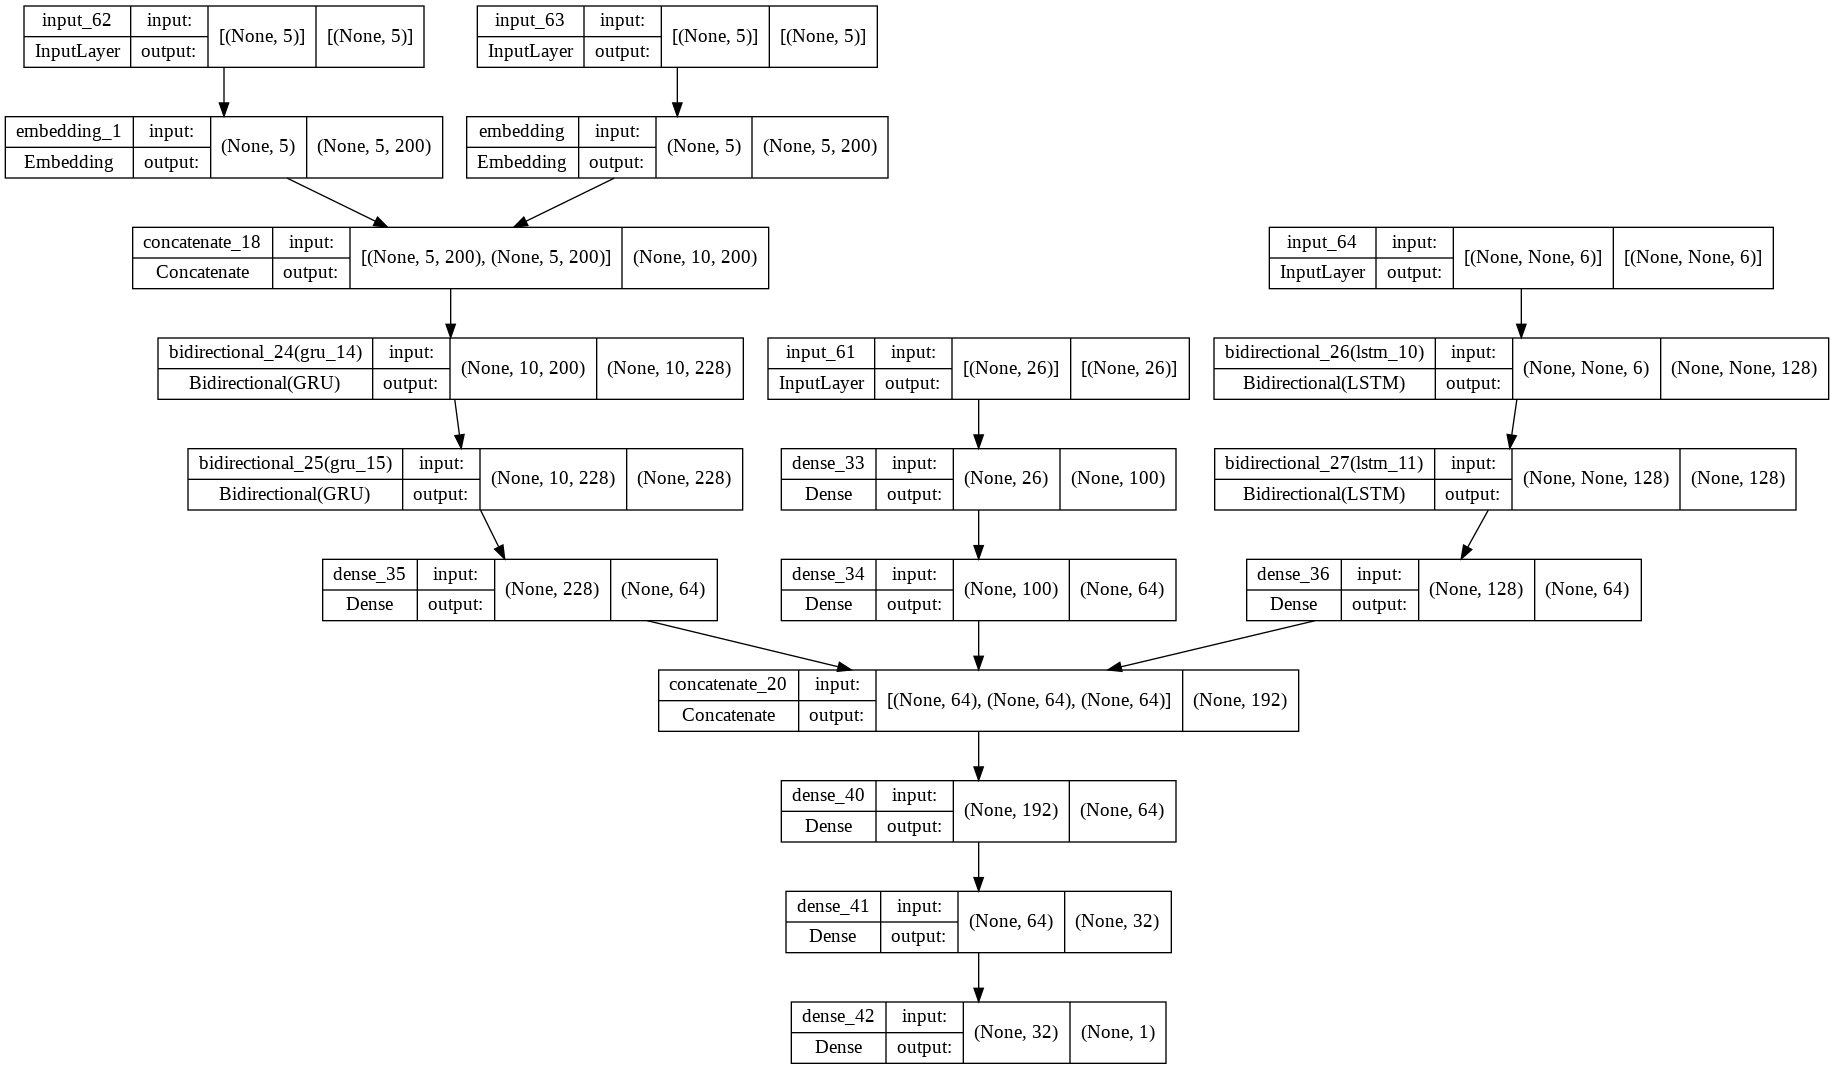

In [100]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [101]:
x_test = vectorizer(np.array([[s] for s in test_samples_chief])).numpy()
x_test_his = vectorizer_his(np.array([[s] for s in test_samples_his])).numpy()
x_test_o = trans_pip.transform(test_samples_o)
x_test_vi = np.array([s for s in test_samples_vital])
y_test = np.array(test_labels)

In [116]:
y_test_pred = model.predict(x=[x_test_o,x_test_his, x_test, x_test_vi])

print("roc auc for validation set:", roc_auc_score(y_test, y_test_pred))




roc auc for validation set: 0.931263765689783


In [130]:
y_pred_test_class = np.where(y_test_pred> 0.000001, 1, 0)
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
print("f1 score for test set:", f1_score(y_test, y_pred_test_class))
confusion_matrix(y_test, y_pred_test_class)

accuracy score for test set: 0.9736746952819735
f1 score for test set: 0.04968421052631579


array([[83419,  2237],
       [   20,    59]])

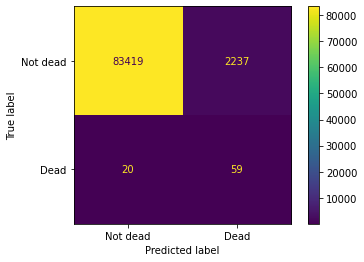

In [131]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_class), display_labels = ["Not dead","Dead"])
disp.plot()
plt.show()